In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import minimize
import yfinance as yf
import seaborn as sns
%load_ext autoreload
%autoreload 2
import Risk_kit as rk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
#getting data from yfinance
tickers = ['RVNL.NS', 'IRFC.NS', 'RECLTD.NS', 'NHPC.NS', 'POWERGRID.NS', 'ZOMATO.NS', 'COCHINSHIP.NS', 'IRB.NS', 'SJVN.NS', 'NBCC.NS']
data = yf.download(tickers, start='2021-7-9', end='2024-7-9') #fetching monthly data for 3 years
price_data=data['Close'] #taking the closing price to determine returns
returns = price_data[tickers].pct_change().dropna()
returns.dropna(inplace=True)
rets = pd.DataFrame(returns)

[*********************100%***********************]  10 of 10 completed


In [38]:
cov_matrix = rets.cov() #to get covariance between the assets
cov_matrix.head()

,RVNL.NS,IRFC.NS,RECLTD.NS,NHPC.NS,POWERGRID.NS,ZOMATO.NS,COCHINSHIP.NS,IRB.NS,SJVN.NS,NBCC.NS
RVNL.NS,0.001177,0.000607,0.000263,0.000283,0.000110,0.000192,0.000388,0.000352,0.000441,0.000374
IRFC.NS,0.000607,0.000814,0.000245,0.000234,0.000106,0.000152,0.000306,0.000304,0.000357,0.000318
RECLTD.NS,0.000263,0.000245,0.000590,0.000222,0.000181,0.000152,0.000215,0.000256,0.000275,0.000292
NHPC.NS,0.000283,0.000234,0.000222,0.000569,0.000137,0.000117,0.000214,0.000243,0.000426,0.000304
POWERGRID.NS,0.000110,0.000106,0.000181,0.000137,0.000294,0.000070,0.000097,0.000160,0.000176,0.000156


In [39]:
#calculating annualized returns using the function from the risk module
ann_rets = pd.Series(rk.annualized_returns(rets))
ann_rets

0    1.752382
1    1.109892
2    0.779603
3    0.611690
4    0.389460
5    0.189053
6    1.551049
7    0.600666
8    0.776034
9    0.586681
dtype: float64

<Axes: >

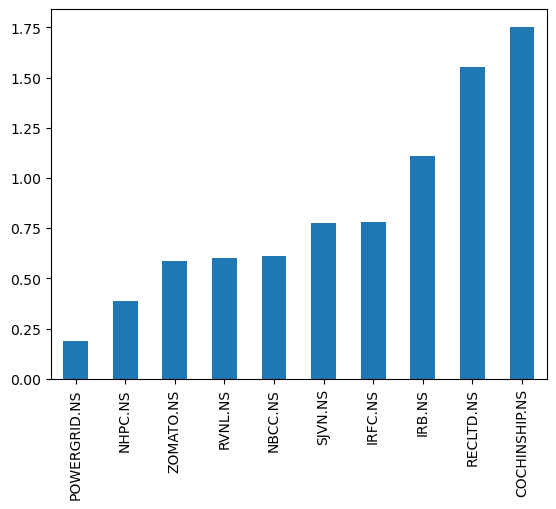

In [40]:
#plotting the annual returns of the assets
column_names = price_data.columns
ann_rets.index=column_names
ann_rets.sort_values().plot.bar()

In [47]:
#calculating weights to optimize for the maximum sharpe ratio using msr function from the risk module
weights=rk.msr(0.03,ann_rets, cov_matrix)
#return of the optimized portfolio
r=rk.portfolio_return(weights,ann_rets)
#volatility of the optimized portfolio
vol=rk.portfolio_vol(weights,cov_matrix)

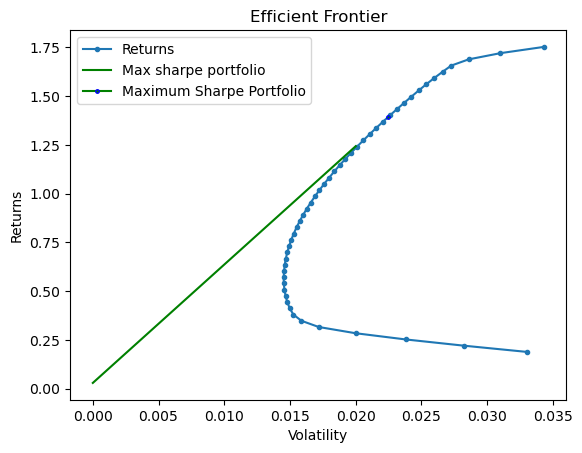

In [48]:
#PLotting the efficient frontier, and locating the portfolio having maximum Sharpe ratio
rk.plot_ef(50, ann_rets, cov_matrix)
#Plotting the line for returns of the risk free asset (risk free returns = 3%)
x=[0,0.020]
y=[0.03,0.020*(r-0.03)/vol+0.03]
plt.title("Efficient Frontier")
plt.plot(x,y,label='Max sharpe portfolio',color="green")
plt.plot(vol,r, color='green', marker='.',markersize=5, markeredgecolor= 'blue',label="Maximum Sharpe Portfolio")
plt.ylabel("Returns")
plt.legend()
plt.show()

In [49]:
sharpe = (r-0.03)/vol
print(f"The return of the portfolio is {r*100}%")
print(f"The volatility of the portfolio is {vol*100}%")
print(f"The Sharpe Ratio of the portfolio is {sharpe}")

The return of the portfolio is 139.45778833132104%
The volatility of the portfolio is 2.2491440110284646%
The Sharpe Ratio of the portfolio is 60.67098756780944


In [ ]:
#CPPI

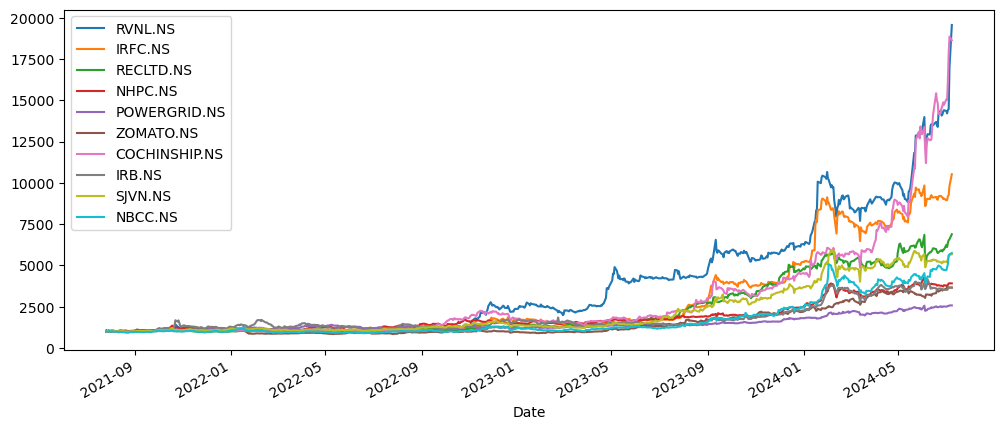

In [50]:
#Taking the same 10 assets as risky assets and using them as risky assets in CPPI
df = rk.run_cppi( rets,safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None)
# plotting the wealth index after running cppi
ax = df["Wealth"].plot(figsize=(12,5))   

<Axes: xlabel='Date'>

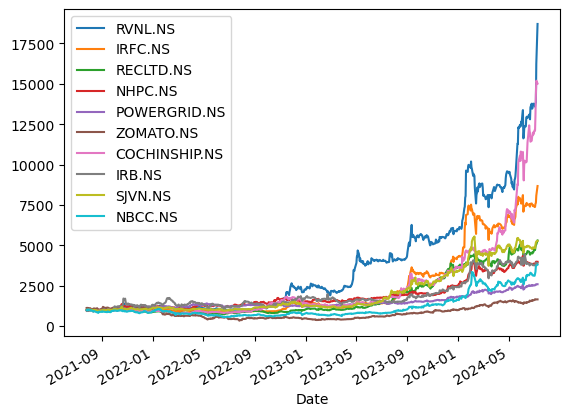

In [51]:
#plotting returns if all the initial amount was placed in the risky asset
df["Risky Wealth"].plot()

In [52]:
#calculating the return series for the portfolio where cppi was used
cppi_rets = df["Wealth"].pct_change().dropna()

In [53]:
#performance of the portfolio
rk.summary_stats(cppi_rets)

,index,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Sharpe Ratio
0,RVNL.NS,1.799902,0.115984,1.638715,10.951256,0.027759,15.259929
1,IRFC.NS,1.258339,0.097328,1.952468,18.729083,0.016058,12.620654
2,RECLTD.NS,0.955094,0.078857,-1.232675,27.116229,0.030739,11.731231
3,NHPC.NS,0.605914,0.081259,-0.152846,10.481663,0.033869,7.087416
4,POWERGRID.NS,0.386916,0.057561,-0.539527,9.290376,0.026223,6.200680
5,ZOMATO.NS,0.530153,0.069873,0.306514,5.410327,0.028491,7.157990
6,COCHINSHIP.NS,1.754202,0.107227,1.733791,12.171951,0.023672,16.079988
7,IRB.NS,0.581050,0.111478,0.854086,8.545832,0.038721,4.943109
8,SJVN.NS,0.819510,0.098440,0.552996,14.935544,0.032465,8.020180
9,NBCC.NS,0.834485,0.089721,1.114775,9.768091,0.027493,8.966499
